# 소프트맥스 회귀
3개 이상의 선택지에서 1개를 선택하는 다중 클래스 분류를 풀기 위한 소프트맥스 회귀

## 5-1 원핫 인코딩
정수인코딩보다 원핫인코딩이 클래스의 성질을 잘 표현한 것
그 이유 MSE를 적용했을때 오차가 균등함

## 5-2 소프트맥스 회귀

원핫 인코딩을 통해 결과값이랑 비교해서 오차를 구함
여기서 오차는 크로스엔트로피 에러를 이용함
로지스틱 회귀에서 사용한 함수식과 같은 함수식임

## 5-3 소프트맥스 회귀 손실함수 구현하기

In [2]:
import torch
import torch.nn.functional as F
torch.manual_seed(1)

In [5]:
# dim = 0 을 통해 0차원에서 소프트맥스을 적용함 
z = torch.FloatTensor([1, 2, 3])
hypothesis = F.softmax(z,dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [6]:
hypothesis.sum()

tensor(1.)

In [7]:
# 손실함수를 직접 구현해보기

# 3X5 텐서 만들기
z = torch.rand(3, 5, requires_grad=True)

# 두번째 차원에서 소프트맥스를 적용시켜야한다는 의미
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)


In [11]:
# 임의의 레이블을 만듬
# 0부터 4사이의 값에서 길이가 3인 텐서를 만듬, 그리고 정수형으로 변경
y = torch.randint(5, (3,)).long()
print(y)

tensor([2, 1, 0])


In [12]:
# 모든 원소가 0의 값을 가진 3 × 5 텐서 생성
# hypothesis와 같은 크기의 모든 원소가 0이도록 만듬
y_one_hot = torch.zeros_like(hypothesis)

# scatter은 원핫 인코딩을 수행하기 위해 사용됨
# 첫번째 인자 1은 scatter할 차원을 나타냄
# y.unsqueeze는 y텐서에 차원을 추가해 3X1로 만들어줌
# 세번째 인자 1은 scatter될 값으로 hot 부분, 해당 인덱스 위치를 1로 만드는 것
y_one_hot.scatter_(1, y.unsqueeze(1), 1)
print(y_one_hot)

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])


In [13]:
# 위에코드 간단한 해석
y.unsqueeze(1) # (3,) 크기가 (3X1)이 됨

tensor([[2],
        [1],
        [0]])

In [14]:
# 크로스 엔트로피 에러 구현 
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.6682, grad_fn=<MeanBackward0>)


### 파이토치 소프트맥스 비용함수 구현(하이레벨)
- F.softmax() + torch.log() = F.log_softmax()
- F.log_softmax() + F.nll_loss() = F.cross_entropy()

In [15]:
# 기존에 사용한 방법
torch.log(F.softmax(z,dim=1))

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward0>)

In [16]:
# 파이토치에서는 두개를 결합한 F.log_softmax()를 제공함 
F.log_softmax(z,dim=1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

In [18]:
# 위에서 구현한 비용함수
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.6682, grad_fn=<MeanBackward0>)

In [20]:
# 여기서 위에서 배운 log softmax를 적용하면
(y_one_hot * -torch.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.6682, grad_fn=<MeanBackward0>)

In [21]:
# 여기서 nll_loss를 사용하면 원핫벡터를 넣을 필요없이 실제 값을 인자로 사용 됨
F.nll_loss(F.log_softmax(z, dim=1), y)

# 여기서 nll 이란 Negative Log Likelihood의 약자로 
# nll losssms log softmax를 수행한 후 남은 수식을 의미

tensor(1.6682, grad_fn=<NllLossBackward0>)

In [22]:
# 두개를 합쳐놓은거
F.cross_entropy(z,y)

tensor(1.6682, grad_fn=<NllLossBackward0>)

## 5-4 소프트맥스 회귀 구현하기

In [28]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

In [29]:
# 훈련데이터
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

In [30]:
# 원핫 인코딩
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape) # 3개의 클래스가 있고 8개의 데이터가 있음

torch.Size([8, 3])


In [31]:
# 모델 초기화

W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

In [32]:
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # 가설
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1)

    # 비용 함수
    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704200
Epoch  200/1000 Cost: 0.623000
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515291
Epoch  500/1000 Cost: 0.467662
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375402
Epoch  800/1000 Cost: 0.329766
Epoch  900/1000 Cost: 0.285072
Epoch 1000/1000 Cost: 0.248155


### 하이레벨로 구현

In [33]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train) # 이 부분만 달라진거

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704200
Epoch  200/1000 Cost: 0.623000
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515291
Epoch  500/1000 Cost: 0.467662
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375402
Epoch  800/1000 Cost: 0.329766
Epoch  900/1000 Cost: 0.285073
Epoch 1000/1000 Cost: 0.248155


### nn.Module로 구현

In [34]:
# 모델을 선언 및 초기화. 4개의 특성을 가지고 3개의 클래스로 분류. input_dim=4, output_dim=3.
model = nn.Linear(4, 3)

In [ ]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1) # 이부분이 다른것

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)
    # 이걸 사용하므로 따로 소프트맥스 함수를 가설에 설정하지 않음

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


### 클래스로 구현하기

In [35]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # Output이 3!

    def forward(self, x):
        return self.linear(x)

In [36]:
model = SoftmaxClassifierModel()

In [37]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/1000 Cost: 1.777960
Epoch  100/1000 Cost: 0.654127
Epoch  200/1000 Cost: 0.561501
Epoch  300/1000 Cost: 0.505037
Epoch  400/1000 Cost: 0.460010
Epoch  500/1000 Cost: 0.420253
Epoch  600/1000 Cost: 0.383131
Epoch  700/1000 Cost: 0.347032
Epoch  800/1000 Cost: 0.310780
Epoch  900/1000 Cost: 0.274060
Epoch 1000/1000 Cost: 0.244281


In [39]:
prediction = model(x_train)
prediction

tensor([[-4.2938, -0.2427,  4.6913],
        [-2.3290,  0.9101,  2.8455],
        [-6.6588,  3.7306,  4.8623],
        [-5.0665,  4.6850,  3.5495],
        [ 1.1661,  1.5396, -1.7634],
        [ 2.2749,  3.6155, -4.8383],
        [ 3.3692,  2.4313, -4.5762],
        [ 4.8273,  2.9265, -6.3231]], grad_fn=<AddmmBackward0>)

## 5-5 소프트맥스 회귀로 MNIST 데이터 분류하기

In [40]:
import torch 
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [41]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음기기로 학습합니다.", device)

다음기기로 학습합니다. cpu


In [42]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed(777)

In [43]:
# hyperparameters
training_epochs = 15
batch_size = 100

In [44]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운받을 경로
                          train=True, # 이걸 true로 주면 훈련데이터를, false면 테스트데이터
                          transform=transforms.ToTensor(), # 텐서로 변환해줌
                          download=True) # 해당 경로에 없으면 다운로드 받겠다는 의미

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

100%|██████████| 9912422/9912422 [00:02<00:00, 4943311.47it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 2081190.51it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5884893.38it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1049442.45it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


In [45]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train, # 로드할 데이터를 의미
                         batch_size=batch_size, # 배치 크기는 100
                         shuffle=True, # 매 에폭마다 미니배치를 셔플할 것인지
                         drop_last=True) # 마지막 배치는 머릴 것인지를 의미
                            # 마지막 미니배치는 갯수가 부족할 수 있으므로 버릴 수 있고 
                            # 이는 과대적합을 막아줌


In [46]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)
# 입력차원 784 출력 차원 10
# to 함수는 모델의 매개변수를 지정한 장치의 메모리로 보냄
# cpu면 따로 명시할 필요가 없지만, gpu면 지정해줄 필요가 있음
# bias는 편향 b를 사용할건지를 나타냄. 디폴트가 True

In [47]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [48]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')


Epoch: 0001 cost = 0.535150647
Epoch: 0002 cost = 0.359577745
Epoch: 0003 cost = 0.331264228
Epoch: 0004 cost = 0.316404670
Epoch: 0005 cost = 0.307107002
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956199
Epoch: 0009 cost = 0.287074089
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281914026
Epoch: 0012 cost = 0.279526860
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874823
Epoch: 0015 cost = 0.274422735
Learning finished


Accuracy: 0.8883000016212463
Label:  3
Prediction:  3


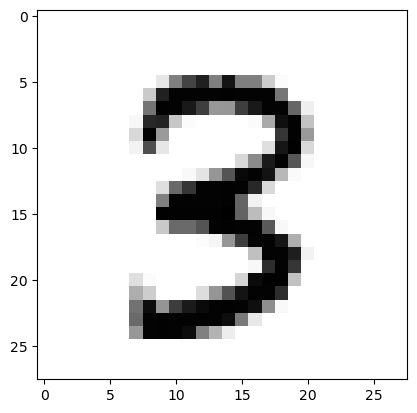

In [53]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()
